# Adult dataset

For the Final Project, we will do statistical analysis on the Census Income dataset available at the UC
Irvine Machine Learning Repository.

Here is the information on the dataset:
- Dataset Characteristics: Multivariate
- Subject Area: Social Science
- Associated Tasks: Classification
- Feature Type: Categorical, Integer
- No. of Instances: 48842
- No. of Features: 14

In [1]:
# import libraries

import pandas as pd
from matplotlib import gridspec
import math
import matplotlib.pyplot as plt
import random
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.svm import SVC
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report


# columns of interest
column_names = [
    'age',
    'workclass',
    'fnlwgt',
    'education',
    'education-num',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'capital-gain',
    'capital-loss',
    'hours-per-week',
    'native-country',
    'income',
]

# read data
df = pd.read_csv('adult/adult.data', names=column_names)

# get smaller chunk of data if desired
do_split = False
if do_split:
    df_shuffled = df.sample(frac=1,random_state = 51)
    result = np.array_split(df_shuffled, 50)
    data = result[0]
    n = data.shape[0]
    data.index = range(0,n)
else:
    data = df


In [2]:
# data cleanup

# initial data shape
print(data.shape)

# replace missing values
data.replace("?", np.NaN, inplace=True)
data.replace(" ?", np.NaN, inplace=True)

# data preprocessing
# drop rows with missing values
data.dropna(inplace=True)

# final data shape
print(data.shape)


(32561, 15)
(30162, 15)


In [3]:
# get information about the size of the dataset
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


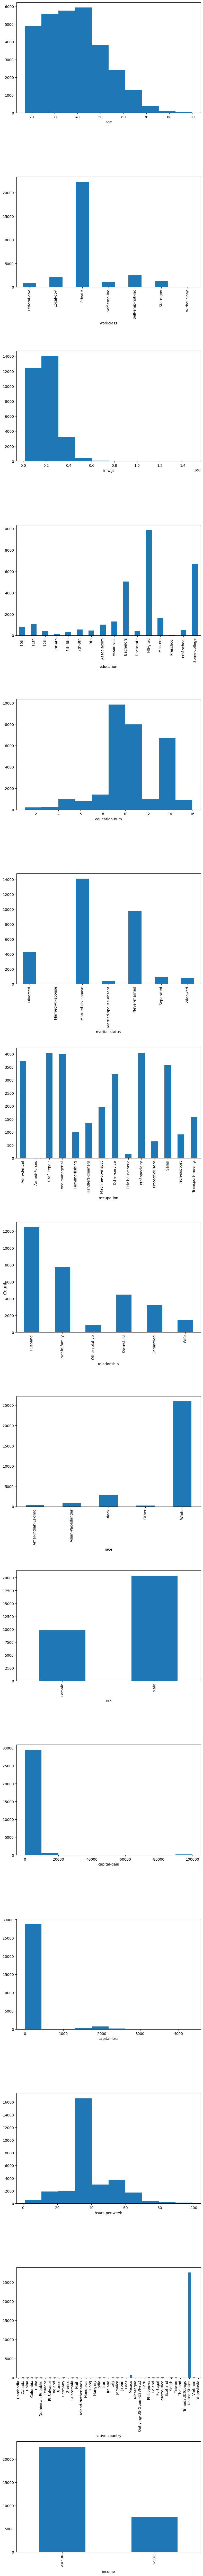

In [4]:
# Plotting function for discrete variables

import math

def discrete_plots(df, columns, num_cols):
    n_plots = len(columns)
    n_cols = num_cols
    n_rows = int(math.ceil(n_plots/n_cols))
    gs = gridspec.GridSpec(n_rows, n_cols)
    fig = plt.figure(figsize=(8,100))
    for i in range(n_plots):
        ax = fig.add_subplot(gs[i])
        if df.dtypes[columns[i]] != 'int64':
            df[columns[i]].value_counts().sort_index().plot(kind='bar', ax=ax)
        else:
            df[columns[i]].hist(ax=ax, grid=False) 
        ax.set_xlabel(columns[i])
    fig.tight_layout()
    fig.supylabel('Count')
    plt.show()

discrete_plots(data,column_names,1)

## Features affecting income level

We consider the following features which can potentially affect the income level.

1. Education
2. Race
3. Occupation
4. Age Category (age divided into bins of 10)
5. Number of years in education

The corresponding barplots are shown below.

Text(0, 0.5, 'Count')

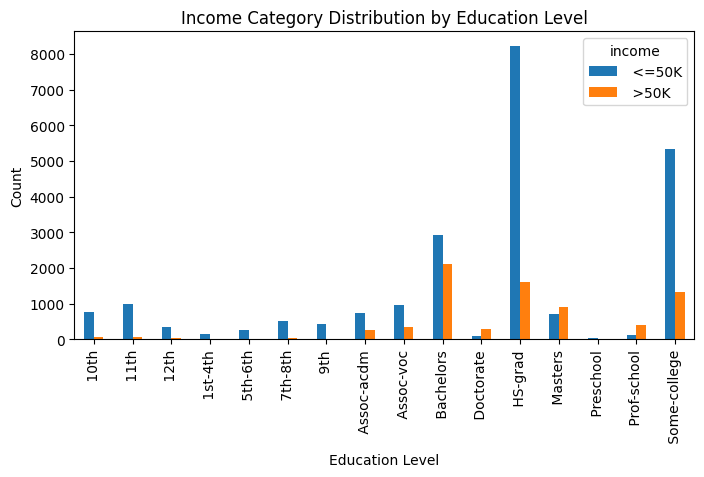

In [5]:
# Group the data by education level and income category
education_income_counts = data.groupby(['education', 'income']).size().unstack()

# Grouped bar plot
education_income_counts.plot(kind='bar', stacked=False, figsize=(8, 4))

# Add labels and title
plt.title('Income Category Distribution by Education Level')
plt.xlabel('Education Level')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

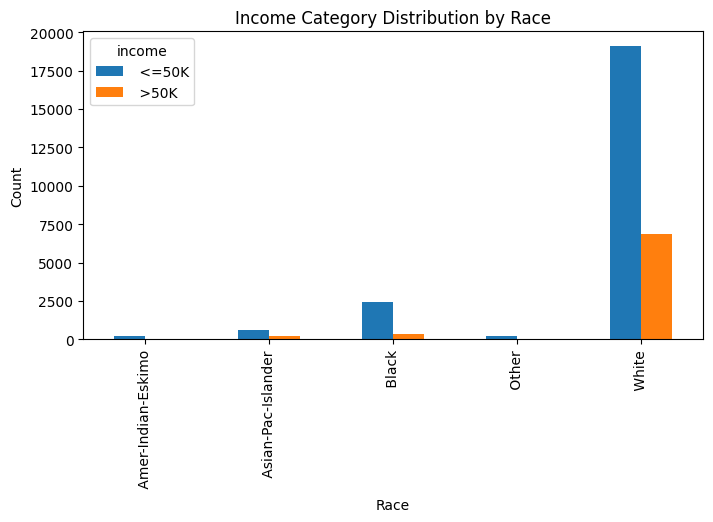

In [6]:
# Group the data by race and income category
race_income_counts = data.groupby(['race', 'income']).size().unstack()

# Grouped bar plot
race_income_counts.plot(kind='bar', stacked=False, figsize=(8, 4))

# Add labels and title
plt.title('Income Category Distribution by Race')
plt.xlabel('Race')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

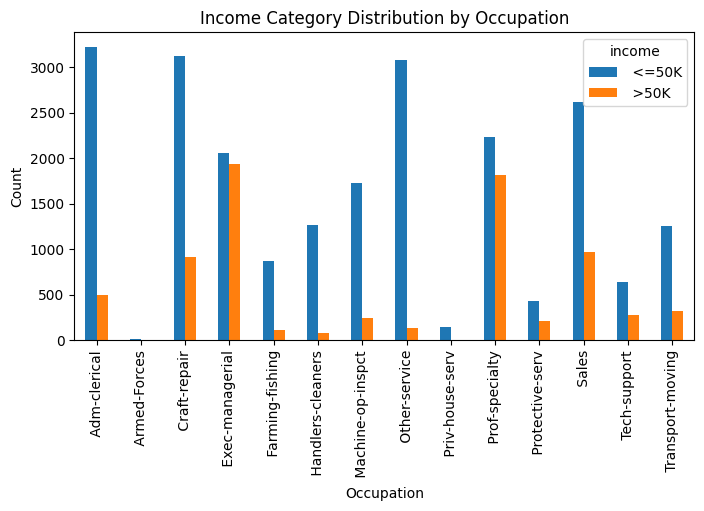

In [7]:
# Group the data by occupation and income category
occupation_income_counts = data.groupby(['occupation', 'income']).size().unstack()

# Grouped bar plot
occupation_income_counts.plot(kind='bar', stacked=False, figsize=(8, 4))

# Add labels and title
plt.title('Income Category Distribution by Occupation')
plt.xlabel('Occupation')
plt.ylabel('Count')

In [8]:
# converting age to categorical data

print('Min age = ', np.min(data['age']))
print('Max age = ', np.max(data['age']))      

bins = [10,20,30,40,50,60,70,80,90]
labels = ['10-20','20-30','30-40','40-50','50-60','60-70','70-80','80-90']

data['age_category'] = pd.cut(data['age'], bins=bins, labels=labels, right=False)

data.head()

Min age =  17
Max age =  90


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,age_category
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,30-40
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,50-60
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,30-40
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,50-60
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,20-30


Text(0, 0.5, 'Count')

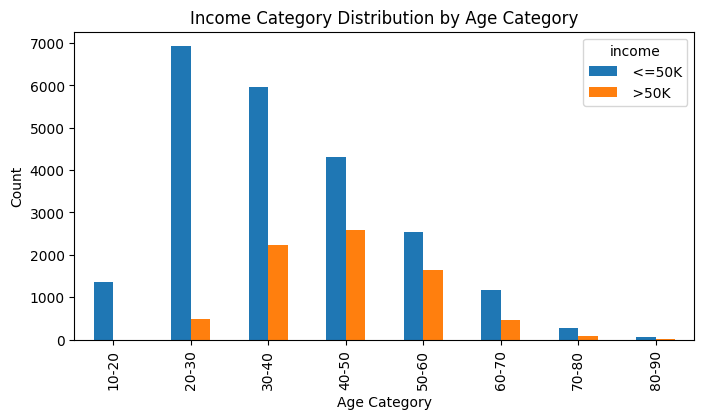

In [9]:
# Group the data by age and income category
age_income_counts = data.groupby(['age_category', 'income'], observed=False).size().unstack()

# Grouped bar plot
age_income_counts.plot(kind='bar', stacked=False, figsize=(8, 4))

# Add labels and title
plt.title('Income Category Distribution by Age Category')
plt.xlabel('Age Category')
plt.ylabel('Count')

## Counts for data columns

To find the counts for the data columns 'income','education','race', and 'occupation' we use the following code.

Text(0, 0.5, 'Count')

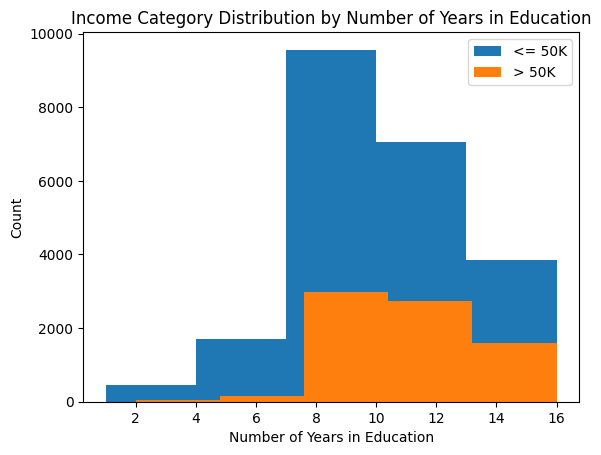

In [15]:
grouped_data = {}
for category, values in zip(data['income'], data['education-num']):
    grouped_data.setdefault(category, []).append(values)

# Plotting histogram for each category
plt.figure()
for category, values in grouped_data.items():
    plt.hist(values, bins=5, label=category)

# Add labels and title
plt.title('Income Category Distribution by Number of Years in Education')
plt.legend(['<= 50K','> 50K'])
plt.xlabel('Number of Years in Education')
plt.ylabel('Count')

In [16]:
# Correlations

correlation_education = np.corrcoef(data['education'], data['income'])[0, 1]
print("Correlation = %.5f" %correlation_education)

TypeError: unsupported operand type(s) for /: 'str' and 'int'

In [11]:
# income counts
income_acounts = data['income'].value_counts()
# sorting income count by descending order
income_counts_sorted = income_counts.sort_values(ascending=False)
# display the sorted income levels and their counts
print(income_counts_sorted)

# ---------------

# education counts
education_counts = data['education'].value_counts()
# sorting education count by descending order
education_counts_sorted = education_counts.sort_values(ascending=False)
# display the sorted education levels and their counts
print(education_counts_sorted)

# ---------------

# race counts
race_counts = data['race'].value_counts()
# sorting race count by descending order
race_counts_sorted = race_counts.sort_values(ascending=False)
# display the sorted race and their counts
print(race_counts_sorted)

# ---------------

# occupation counts
occupation_counts = data['occupation'].value_counts()
# sorting occupation count by descending order
occupation_counts_sorted = occupation_counts.sort_values(ascending=False)
# display the sorted occupation and their counts
print(occupation_counts_sorted)

# ---------------

# age category counts
age_counts = data['age_category'].value_counts()
# sorting occupation count by descending order
age_counts_sorted = age_counts.sort_values(ascending=False)
# display the sorted occupation and their counts
print(age_counts_sorted)


income
 <=50K    22654
 >50K      7508
Name: count, dtype: int64
education
 HS-grad         9840
 Some-college    6678
 Bachelors       5044
 Masters         1627
 Assoc-voc       1307
 11th            1048
 Assoc-acdm      1008
 10th             820
 7th-8th          557
 Prof-school      542
 9th              455
 12th             377
 Doctorate        375
 5th-6th          288
 1st-4th          151
 Preschool         45
Name: count, dtype: int64
race
 White                 25933
 Black                  2817
 Asian-Pac-Islander      895
 Amer-Indian-Eskimo      286
 Other                   231
Name: count, dtype: int64
occupation
 Prof-specialty       4038
 Craft-repair         4030
 Exec-managerial      3992
 Adm-clerical         3721
 Sales                3584
 Other-service        3212
 Machine-op-inspct    1966
 Transport-moving     1572
 Handlers-cleaners    1350
 Farming-fishing       989
 Tech-support          912
 Protective-serv       644
 Priv-house-serv       143
 Armed-Fo

In [12]:
mean_hours = np.mean(df['hours-per-week'])
std_hours = np.std(df['hours-per-week'])

print("Mean hours-per-week = %.2f" % mean_hours)
print("Standard Deviation hours-per-week = %.2f" % std_hours)

Mean hours-per-week = 40.93
Standard Deviation hours-per-week = 11.98


# Machine learning:

We have used the following five classifiers for our analysis:
- Support Vector Machine Classifier
- Logistic Regression
- Decision Tree Classifier
- Random Forest Classifier
- Gradient Boosting Classifier

Out initial consideration are the following features:

1. Education
2. Race
3. Occupation
4. Age Category (age divided into bins of 10)
5. Education Number (number of years spent in education)

We split the dataset into 80% for train and 20% for test. The training data consists of X_train and y_train, and the test data consists of X_test and y_test.

After training the classifiers using X_train and Y_train, we test it using X_test and y_test.

The classification report for each classifier are printed as the end of each code cell. All of the classifiers have very similar performance.

In [14]:
# SVC Classifier

# Get X and y
X = pd.get_dummies(data[['education','race', 'occupation', 'age_category', 'education-num']])
y = data['income']

# Split data into training and testing sets
np.random.seed(123)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

svc = SVC(random_state=42)
svc.fit(X_train, y_train)

# Predict
y_pred = svc.predict(X_test)

# Classification report
report = classification_report(y_test, y_pred)
print(report)


              precision    recall  f1-score   support

       <=50K       0.82      0.93      0.87      4503
        >50K       0.65      0.38      0.48      1530

    accuracy                           0.79      6033
   macro avg       0.73      0.66      0.68      6033
weighted avg       0.77      0.79      0.77      6033



In [15]:
# Logistic Regression

logistic = LogisticRegression(random_state=42, max_iter = 10000)
logistic.fit(X_train, y_train)

# Predict
y_pred = logistic.predict(X_test)

# Classification report
report = classification_report(y_test, y_pred)
print(report)


              precision    recall  f1-score   support

       <=50K       0.82      0.93      0.87      4503
        >50K       0.66      0.40      0.50      1530

    accuracy                           0.80      6033
   macro avg       0.74      0.67      0.69      6033
weighted avg       0.78      0.80      0.78      6033



In [16]:
# import library
from sklearn.tree import DecisionTreeClassifier

# Initializing and training the Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)

# Making predictions
y_pred = dt_classifier.predict(X_test)

# Evaluating the model
# accuracy = accuracy_score(y_test, y_pred)
# print(f'Decision Tree Classifier Accuracy: {accuracy}')

# Classification report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

       <=50K       0.82      0.92      0.87      4503
        >50K       0.64      0.41      0.50      1530

    accuracy                           0.79      6033
   macro avg       0.73      0.67      0.69      6033
weighted avg       0.78      0.79      0.78      6033



In [17]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

# Initializing and training the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Making predictions
y_pred = rf_classifier.predict(X_test)

# Evaluating the model
# accuracy_rf = accuracy_score(y_test, y_pred_rf)
# print(f'Random Forest Classifier Accuracy: {accuracy_rf}')

# Classification report
report = classification_report(y_test, y_pred)
print(report)


              precision    recall  f1-score   support

       <=50K       0.82      0.91      0.87      4503
        >50K       0.63      0.43      0.51      1530

    accuracy                           0.79      6033
   macro avg       0.73      0.67      0.69      6033
weighted avg       0.78      0.79      0.78      6033



In [18]:
# Gradient Boosting Machines Classifer

from sklearn.ensemble import GradientBoostingClassifier

# Initializing and training the GBM Classifier
gbm_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gbm_classifier.fit(X_train, y_train)

# Making predictions
y_pred = gbm_classifier.predict(X_test)

# Evaluating the model
# accuracy_gbm = accuracy_score(y_test, y_pred_gbm)
# print(f'Gradient Boosting Machines Classifier Accuracy: {accuracy_gbm}')

# Classification report
report = classification_report(y_test, y_pred)
print(report)


              precision    recall  f1-score   support

       <=50K       0.82      0.92      0.87      4503
        >50K       0.65      0.42      0.51      1530

    accuracy                           0.80      6033
   macro avg       0.74      0.67      0.69      6033
weighted avg       0.78      0.80      0.78      6033

